In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from joblib import dump, load
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
import seaborn as sns

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\AEPAC\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
#Read Data
df = pd.read_csv("airline_sentiment_analysis.csv")
df.head()

,Unnamed: 0,airline_sentiment,text
0,1,positive,@VirginAmerica plus you've added commercials t...
1,3,negative,@VirginAmerica it's really aggressive to blast...
2,4,negative,@VirginAmerica and it's a really big bad thing...
3,5,negative,@VirginAmerica seriously would pay $30 a fligh...
4,6,positive,"@VirginAmerica yes, nearly every time I fly VX..."


negative    9178
positive    2363
Name: airline_sentiment, dtype: int64

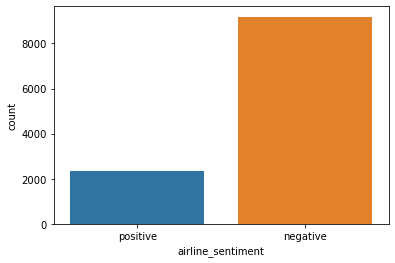

In [5]:
#Plot Data
sns.countplot(df.airline_sentiment)
df.airline_sentiment.value_counts()

In [6]:
#Take Same number of records for each class 
df_neg = df[df['airline_sentiment'] == 'negative']
df_neg = df_neg.iloc[:2363, :]
df_pos = df.drop(df[df['airline_sentiment'] == 'negative'].index)
stratified_dataset = pd.concat([df_pos, df_neg])
stratified_dataset = stratified_dataset.sample(frac=1)
stratified_dataset

,Unnamed: 0,airline_sentiment,text
988,1305,negative,@united never ever again will I be Flight Book...
6961,9269,positive,@USAirways Thanks! Sent you DM re: baggage iss...
2462,3076,negative,@united your airline is the biggest joke of an...
3093,3870,positive,@united -today the staff @ MSP took customer s...
2471,3087,negative,@united how are you going to rectify this? Ple...
...,...,...,...
2406,3004,negative,@united https://t.co/jpd7NsGRT7. Fyi your staf...
2692,3353,negative,@united the wifi in the ewr lounge reminds me ...
1790,2259,positive,@united tonight you made this Fred Flintstone ...
9228,11862,positive,"@USAirways thanks for the reply, hoping everyt..."


negative    2363
positive    2363
Name: airline_sentiment, dtype: int64

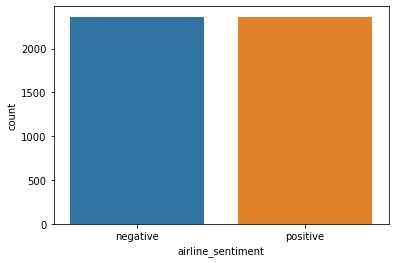

In [7]:
sns.countplot(stratified_dataset.airline_sentiment)
stratified_dataset.airline_sentiment.value_counts()

In [8]:
#Shuffle 
stratified_dataset = stratified_dataset.reindex(np.random.permutation(stratified_dataset.index))
stratified_dataset = stratified_dataset[['text', 'airline_sentiment']]
stratified_dataset

,text,airline_sentiment
379,@united Shame that there's no flex to tickets ...,negative
4854,@SouthwestAir @love_dragonss LAUREN IM SCREAMING,positive
3636,@SouthwestAir thank you :),positive
1563,@united I am - thank you!,positive
244,@VirginAmerica ok! first time flying with you ...,positive
...,...,...
9490,@AmericanAir @dfwairport me too!! LOVE LIVING...,positive
145,@VirginAmerica twitter team. you guys killed i...,positive
2313,@united actually we aren't. Still parked here.,negative
5369,Why “@JetBlue: Our fleet's on fleek. http://t....,positive


In [16]:
class Preprocess:
    def removeExtras(self, review):
        review = review = re.sub(r'@+([a-zA-Z_][a-zA-Z_0-9]*)\s*', ' ', review)
        review = re.sub('[^a-zA-Z]', ' ', review)
        review = review.lower()
        review = review.split()
        ps = PorterStemmer()
        all_stopwords = stopwords.words('english')
        all_stopwords.remove('not')
        review = [ps.stem(word) for word in review if not word in set(all_stopwords)]
        review = ' '.join(review)
        return review
    
    def formatData(self, stratified_dataset):
        Corpus = stratified_dataset['text'].values.tolist()
        cv = CountVectorizer(max_features = 1500)
        X = cv.fit_transform(Corpus).toarray()
        y = stratified_dataset['airline_sentiment'].values.tolist()
        y = np.array(y)
        lb = LabelEncoder()
        y = lb.fit_transform(y)
        return X, y, Corpus

In [18]:
preprocess = Preprocess()
stratified_dataset.text = stratified_dataset['text'].apply(preprocess.removeExtras)

In [19]:
#Check data
stratified_dataset

,text,airline_sentiment
379,shame flex ticket transfer rule even call neur...,negative
4854,lauren im scream,positive
3636,thank,positive
1563,thank,positive
244,ok first time fli tonight,positive
...,...,...
9490,love live close alway great view,positive
145,twitter team guy kill reschedul asap thank,positive
2313,actual still park,negative
5369,fleet fleek http co nvbj ipx,positive


In [20]:
#Preprocess data and find X, y and corpus
X, y, corpus = preprocess.formatData(stratified_dataset)

In [25]:
#Split into train test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 0)

In [26]:
#Train and validate
classifier = XGBClassifier()
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
print(np.concatenate((y_pred.reshape(len(y_pred),1), y_test.reshape(len(y_test),1)),1))

[[1 1]
 [0 0]
 [0 0]
 ...
 [0 0]
 [0 0]
 [1 0]]


In [27]:
#Check Classifier Performance
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
cm = confusion_matrix(y_test, y_pred)
print(cm)
accuracy_score(y_test, y_pred)
print(classification_report(y_test, y_pred))

[[417  54]
 [ 63 412]]
              precision    recall  f1-score   support

           0       0.87      0.89      0.88       471
           1       0.88      0.87      0.88       475

    accuracy                           0.88       946
   macro avg       0.88      0.88      0.88       946
weighted avg       0.88      0.88      0.88       946



In [28]:
#Save corpus for future use
dump(corpus, 'Corpus.joblib')

['Corpus.joblib']

In [29]:
# Save classifier for future use
dump(classifier, 'sentimentClassifier.joblib')

['sentimentClassifier.joblib']